# PUHEKOMENNOT TUNNISTAMINEN ÄÄNITTEISTÄ
Tehtävä: Rakenna malli, joka tunnistaa yksinkertaisia puhuttuja komentoja

Aineisto: [Speech Commands Dataset](https://www.tensorflow.org/datasets/catalog/speech_commands)

Aineisto on ladattu ja purettu testi/treeni/validaatio setteihin aineiston mukana tulevien readme-tiedostojen mukaan (TODO: SELITÄ MITÄ NE ON)

Twenty core command words were recorded, with most speakers saying each
of them five times. The core words are "Yes", "No", "Up", "Down", "Left",
"Right", "On", "Off", "Stop", "Go", "Zero", "One", "Two", "Three", "Four",
"Five", "Six", "Seven", "Eight", and "Nine".

To help distinguish unrecognized
words, there are also ten auxiliary words, which most speakers only said once.
These include "Bed", "Bird", "Cat", "Dog", "Happy", "House", "Marvin", "Sheila",
"Tree", and "Wow".

## Datasetin muodostaminen
Käytetään 

In [49]:
import tensorflow as tf
import keras
import keras.utils
import numpy as np
import pathlib

DATASET_PATH = 'split_dataset'
data_dir = pathlib.Path(DATASET_PATH)

# Load the dataset
train_ds = keras.utils.audio_dataset_from_directory(
    str(data_dir) + '/train',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)
val_ds = keras.utils.audio_dataset_from_directory(
    str(data_dir) + '/validation',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)
test_ds = keras.utils.audio_dataset_from_directory(
    str(data_dir) + '/test',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)


Found 72593 files belonging to 26 classes.
Found 8549 files belonging to 26 classes.
Found 9500 files belonging to 26 classes.


In [50]:
label_names = np.array(train_ds.class_names)
print("label names:", label_names)

label names: ['Unknown' 'backward' 'down' 'eight' 'five' 'follow' 'forward' 'four' 'go'
 'learn' 'left' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'six' 'stop'
 'three' 'two' 'up' 'visual' 'yes' 'zero']


This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:

In [51]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [52]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)
  print(example_labels[0])  # Print the label of the first example

(32, 16000)
(32, 26)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)


In [53]:
print("label names:", label_names)

label names: ['Unknown' 'backward' 'down' 'eight' 'five' 'follow' 'forward' 'four' 'go'
 'learn' 'left' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'six' 'stop'
 'three' 'two' 'up' 'visual' 'yes' 'zero']


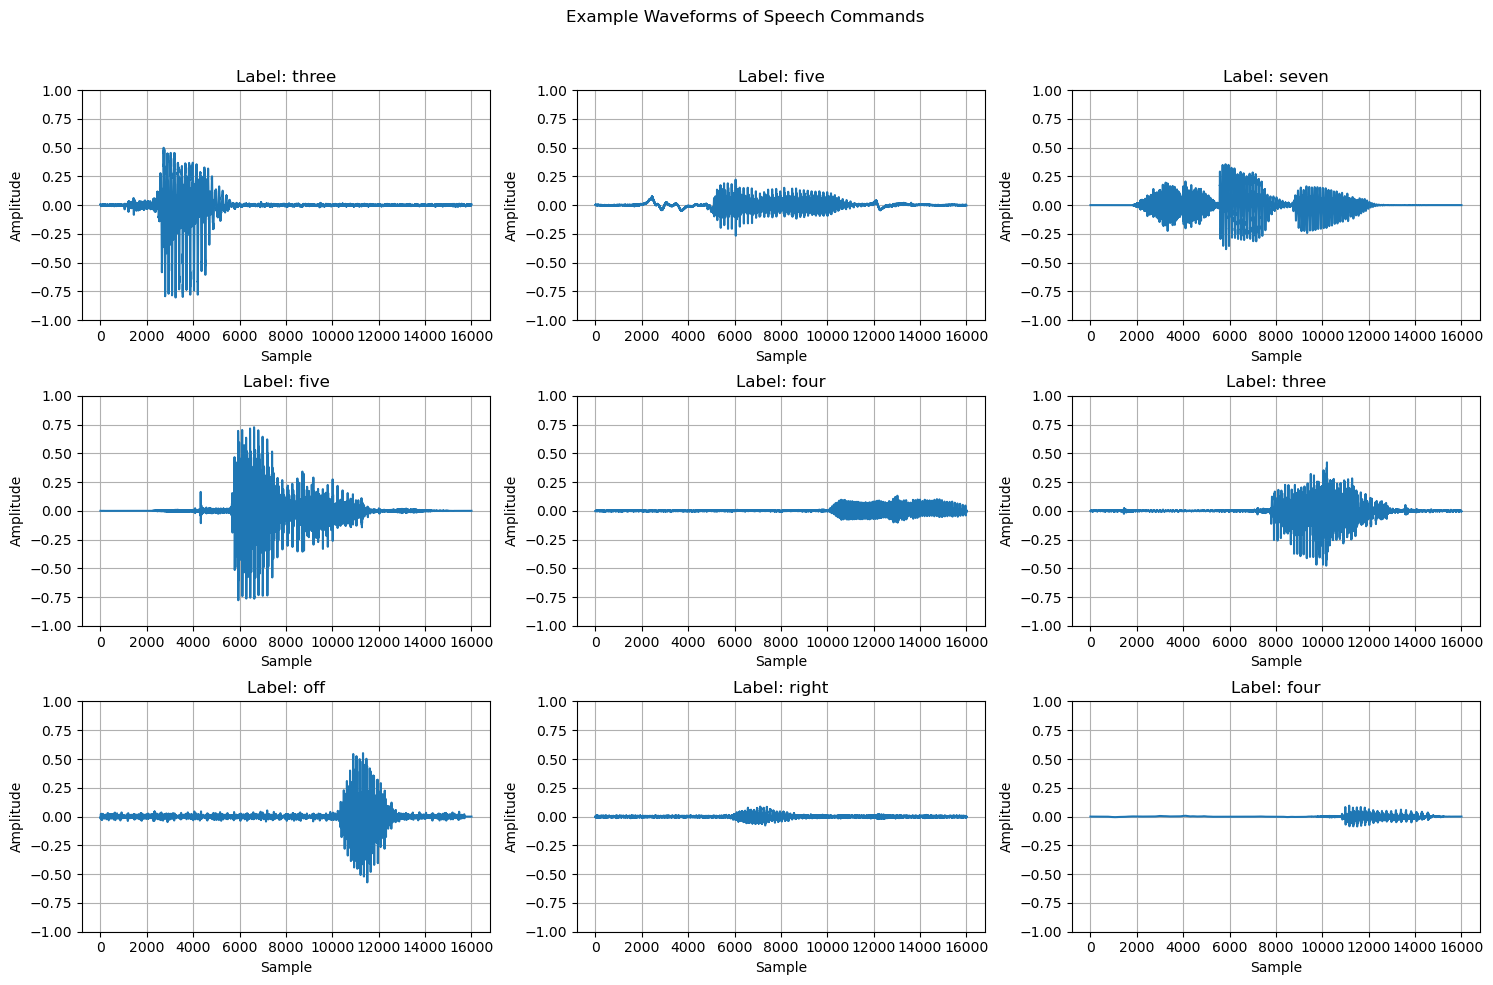

In [54]:
import matplotlib.pyplot as plt

# Function to plot waveforms with their labels
def plot_waveforms(waveforms, labels, num_rows=3, num_cols=3):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    fig.suptitle('Example Waveforms of Speech Commands')
    
    # Flatten axes array for easier iteration
    axes = axes.flatten()
    
    for i, (waveform, label) in enumerate(zip(waveforms, labels)):
        if i >= num_rows * num_cols:
            break
            
        # Get the label index (where the value is 1.0)
        label_idx = tf.argmax(label).numpy()
        label_name = label_names[label_idx]
        
        # Plot the waveform
        axes[i].plot(waveform.numpy())
        axes[i].set_title(f'Label: {label_name}')
        axes[i].set_ylim([-1, 1])
        axes[i].set_xlabel('Sample')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Plot examples from the training dataset
for example_batch, example_labels in train_ds.take(1):
    plot_waveforms(example_batch, example_labels)

## Convert waveforms to spectrograms

### Testataan eri spectrogrammoja

In [55]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [56]:
def get_mel_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Convert to mel scale
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=64,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=16000,
        lower_edge_hertz=0,
        upper_edge_hertz=8000)
    mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(mel_spectrogram.shape[-1:]))
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    mel_spectrogram = mel_spectrogram[..., tf.newaxis]
    return mel_spectrogram

In [57]:
def plot_waveform_and_spectrograms(waveform):
    # Plot the waveform
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(waveform.numpy())
    plt.title('Waveform')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot the spectrogram
    spectrogram = get_spectrogram(waveform)
    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(spectrogram).numpy(), aspect='auto', cmap='inferno')
    plt.title('Spectrogram')
    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency bins')
    plt.colorbar()

    # Plot the mel spectrogram
    mel_spectrogram = get_mel_spectrogram(waveform)
    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(mel_spectrogram).numpy(), aspect='auto', cmap='inferno')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (frames)')
    plt.ylabel('Mel frequency bins')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

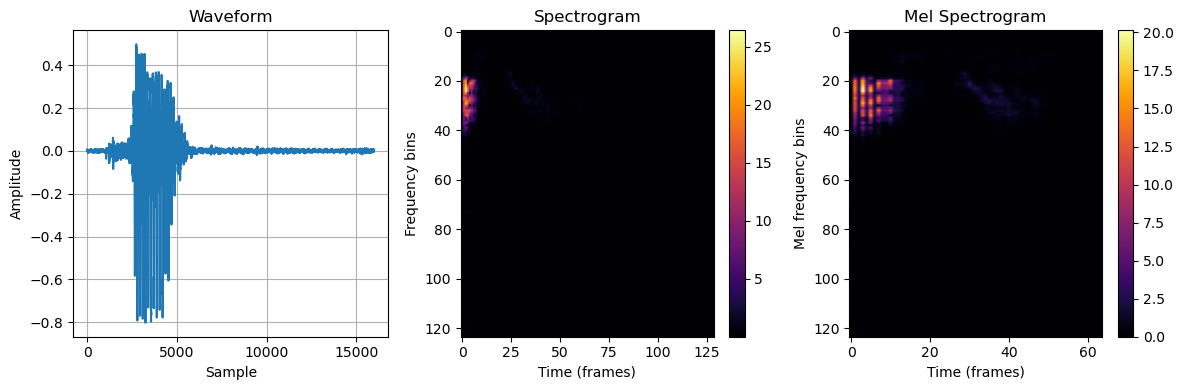

In [58]:
plot_waveform_and_spectrograms(example_batch[0])


In [59]:
def make_spectro_dataset(ds, spectrogram_fn):
    return ds.map(lambda audio, labels: (spectrogram_fn(audio), labels),
                  num_parallel_calls=tf.data.AUTOTUNE)

train_spectro_ds = make_spectro_dataset(train_ds, get_mel_spectrogram)
val_spectro_ds = make_spectro_dataset(val_ds, get_mel_spectrogram)
test_spectro_ds = make_spectro_dataset(test_ds, get_mel_spectrogram)

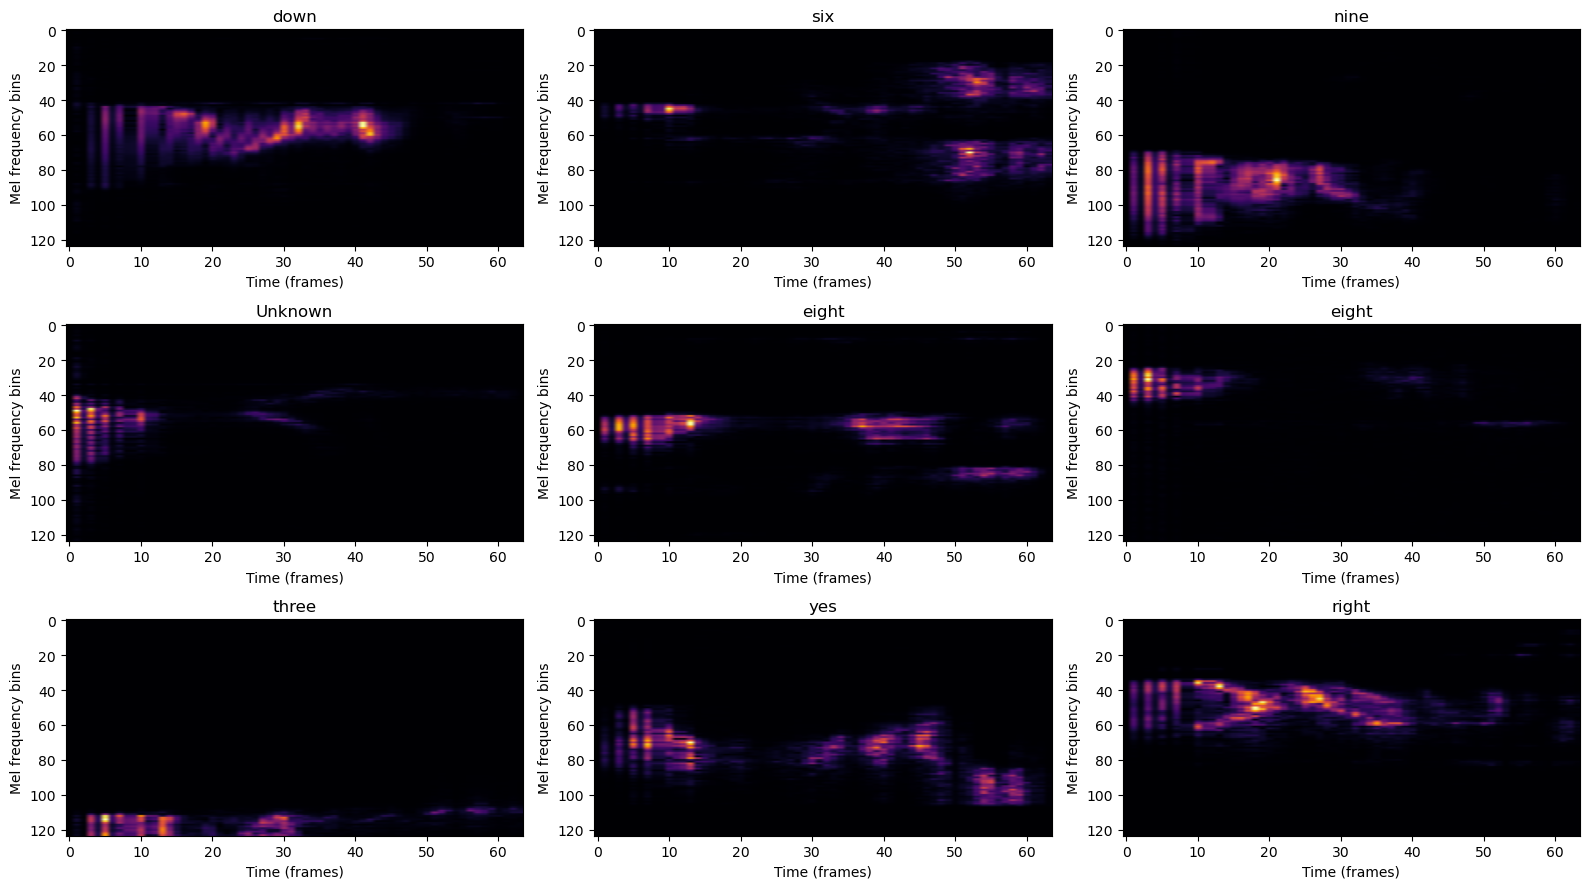

In [60]:
for example_spectrograms, example_spect_labels in train_spectro_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    # Plot the mel spectrogram directly from the example_spectrograms
    ax.imshow(np.squeeze(example_spectrograms[i].numpy()), aspect='auto', cmap='inferno')
    # Get the label index (where the value is 1.0)
    label_idx = tf.argmax(example_spect_labels[i]).numpy()
    ax.set_title(label_names[label_idx])
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Mel frequency bins')

plt.tight_layout()
plt.show()

TODO: tähän jotain kivaa spektrogrammoista

## Treenaus
- 

In [61]:
# Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:
train_spectro_ds = train_spectro_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_spectro_ds = val_spectro_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_spectro_ds = test_spectro_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [62]:
print("Number of classes in dataset:", len(label_names))

Number of classes in dataset: 26


In [63]:
import keras.layers as layers
import keras.models as models

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectro_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Input shape: (124, 64, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,627,933 (6.21 MB)

 Trainable params: 1,627,930 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

In [64]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [65]:
EPOCHS = 3
history = model.fit(
    train_spectro_ds,
    validation_data=val_spectro_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/3
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.4107 - loss: 2.0282 - val_accuracy: 0.7894 - val_loss: 0.7220
Epoch 2/3
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7033 - loss: 0.9746 - val_accuracy: 0.8400 - val_loss: 0.5457
Epoch 3/3
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7508 - loss: 0.8045 - val_accuracy: 0.8470 - val_loss: 0.5098


Text(0, 0.5, 'Accuracy [%]')

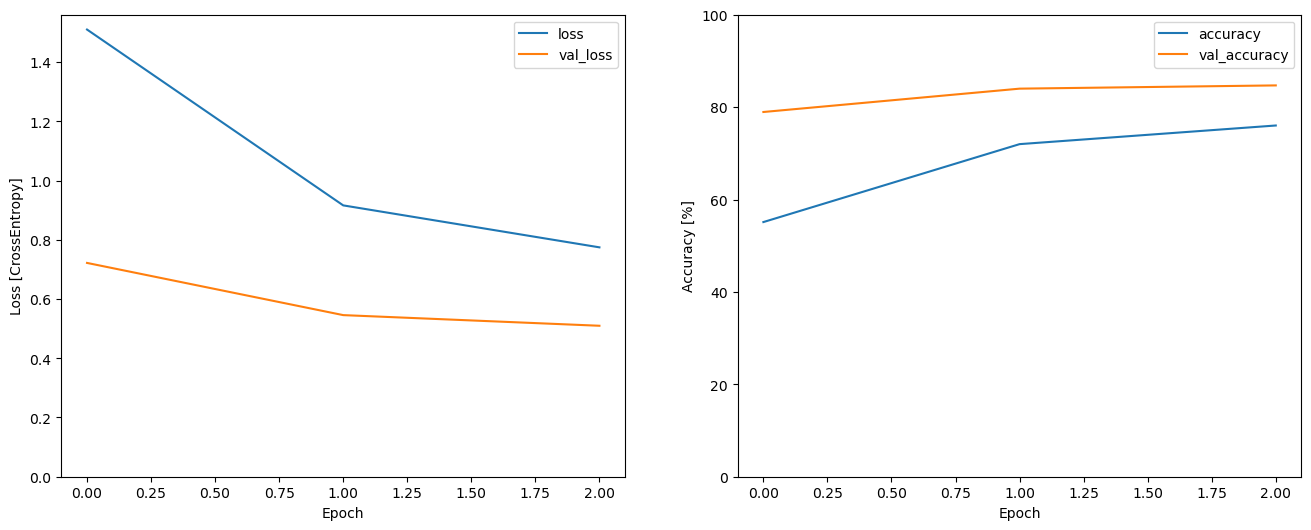

In [66]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [68]:
model.evaluate(test_spectro_ds, return_dict=True)

297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8297 - loss: 0.5451


{'accuracy': 0.8291578888893127, 'loss': 0.549741804599762}

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


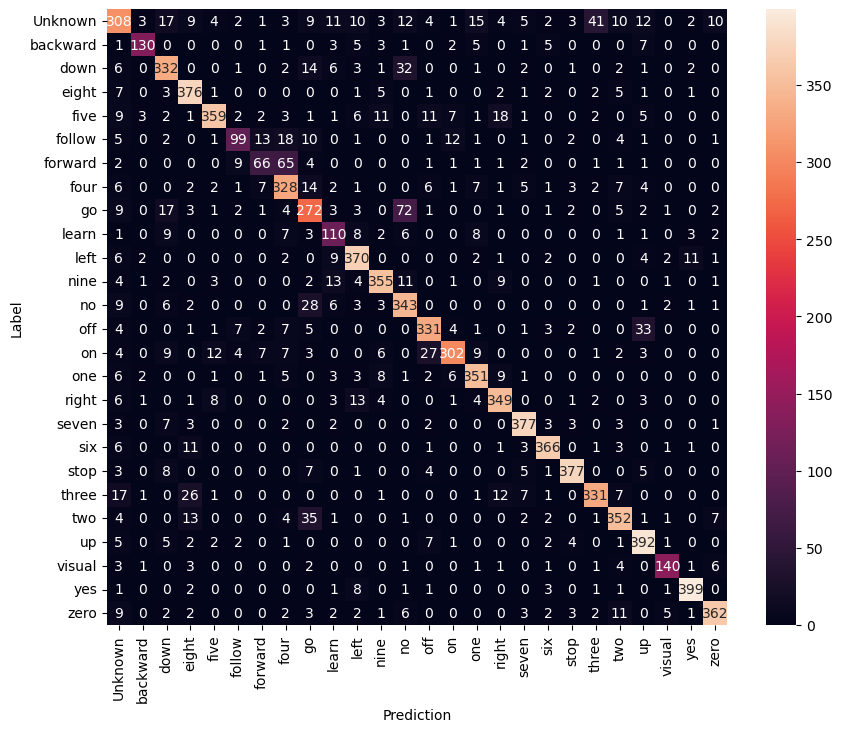

In [70]:
import seaborn as sns

y_pred = model.predict(test_spectro_ds)

# Convert y_true from one-hot encoding to class indices
y_true = tf.concat(list(test_spectro_ds.map(lambda s, lab: tf.argmax(lab, axis=1))), axis=0)

# y_pred is already a vector of class indices
y_pred = tf.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [72]:
def train_model(train_ds, val_ds, test_ds, label_names, epochs=3, batch_size=32, learning_rate=0.001):
    import keras.layers as layers
    import keras.models as models
    import tensorflow as tf
    import matplotlib.pyplot as plt

    # Prepare datasets with caching and prefetching
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Get input shape and number of labels
    for example_spectrograms, _ in train_ds.take(1):
        input_shape = example_spectrograms.shape[1:]
    num_labels = len(label_names)

    # Normalize the data
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

    # Build the model
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation='softmax'),
    ])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'],
    )

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    )

    # Plot training history
    metrics = history.history
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.show()

    # Evaluate the model on the test dataset
    test_results = model.evaluate(test_ds, return_dict=True)
    print("Test results:", test_results)

    return model, history

Epoch 1/5
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3903 - loss: 2.0723 - val_accuracy: 0.8009 - val_loss: 0.7027
Epoch 2/5
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.6944 - loss: 0.9963 - val_accuracy: 0.8327 - val_loss: 0.5707
Epoch 3/5
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7482 - loss: 0.8087 - val_accuracy: 0.8476 - val_loss: 0.5175
Epoch 4/5
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7811 - loss: 0.6972 - val_accuracy: 0.8638 - val_loss: 0.4583
Epoch 5/5
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8017 - loss: 0.6236 - val_accuracy: 0.8665 - val_loss: 0.4419


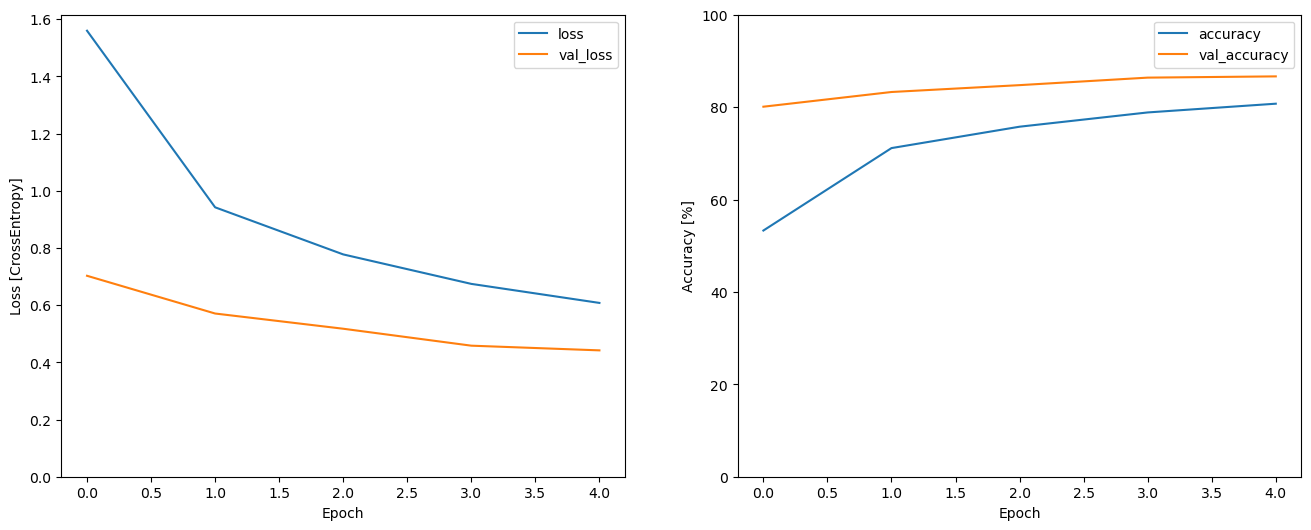

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8565 - loss: 0.4742
Test results: {'accuracy': 0.8572631478309631, 'loss': 0.47935351729393005}
Epoch 1/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.4080 - loss: 2.0252 - val_accuracy: 0.8033 - val_loss: 0.7104
Epoch 2/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7140 - loss: 0.9487 - val_accuracy: 0.8462 - val_loss: 0.5426
Epoch 3/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7638 - loss: 0.7680 - val_accuracy: 0.8567 - val_loss: 0.4790
Epoch 4/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7925 - loss: 0.6717 - val_accuracy: 0.8645 - val_loss: 0.4457
Epoch 5/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8100 - loss: 0.6057 - val_accuracy: 0.8704 - val_loss: 0.4218
Epoch 6/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8281 - loss: 0.5495 - val_accuracy: 0.8754 - val_loss: 0.4198
Epoch 7/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accura

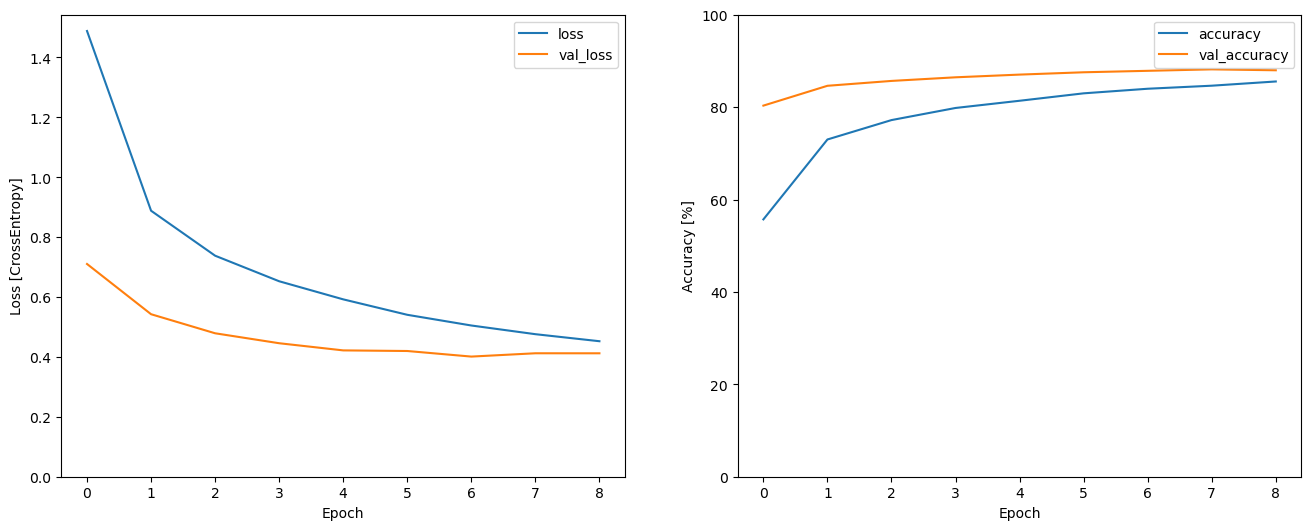

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8765 - loss: 0.4362
Test results: {'accuracy': 0.8767368197441101, 'loss': 0.4359093904495239}


In [73]:
# Train the model 5 and then 10 epochs
trained_model, training_history = train_model(train_spectro_ds, val_spectro_ds, test_spectro_ds, label_names, epochs=5)
trained_model, training_history = train_model(train_spectro_ds, val_spectro_ds, test_spectro_ds, label_names, epochs=10)


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


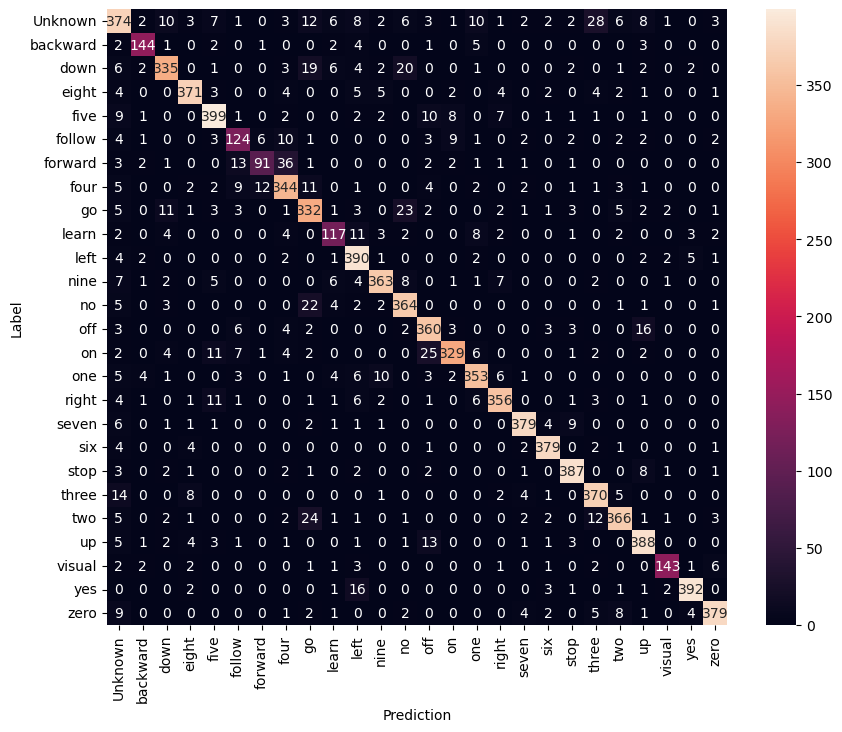

In [74]:
# Confusion matrix for the final model
y_pred = trained_model.predict(test_spectro_ds)
y_true = tf.concat(list(test_spectro_ds.map(lambda s, lab: tf.argmax(lab, axis=1))), axis=0)
y_pred = tf.argmax(y_pred, axis=1)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Tallennetaan hyvä malli

In [ ]:
# Tallennetaan

## Testataan mallia omilla äänitteillä
- Nauhoitimme muutamia äänitiedostoja, ja luokittelimme ne.

##